In [1]:
# ! pip install scikit-image # this one is for skimage

In [2]:
import numpy as np
import cv2
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from skimage.measure import moments_hu, shannon_entropy, label as skimage_label, regionprops
from skimage.morphology import skeletonize
from skimage.color import rgb2gray
from skimage import img_as_ubyte
from scipy.stats import skew, kurtosis
from scipy.fft import fft
import math
import random
import time
import pandas as pd
from sklearn.decomposition import PCA

In [3]:
X = np.load('27-class-sign-language-dataset/X.npy')
y = np.load('27-class-sign-language-dataset/Y.npy')

In [4]:
print(f"Original shapes: X: {X.shape}, y: {y.shape}")

Original shapes: X: (22801, 128, 128, 3), y: (22801, 1)


# Problem! 

There are just too many images and it seems that at least this platform cannot handle them without surpassing the free capacities. That is why, for the sake of actually doing something, we will just take a substract of the overall data.

In [5]:
# due to computational constraints:
max_samples_per_category = 50
unique_labels = np.unique(y)
# Create a list to store the selected images and labels
X_selected = []
y_selected = []

# Randomly select up to 50 images per category
for label in unique_labels:
    # Get indices of all images with the current label
    indices = np.where(y == label)[0]
    
    # Randomly sample up to 50 indices for the current label
    if len(indices) > max_samples_per_category:
        selected_indices = random.sample(list(indices), max_samples_per_category)
    else:
        selected_indices = indices  # Use all images if less than 50
    
    # Append the selected images and labels to the lists
    X_selected.extend(X[selected_indices])
    y_selected.extend(y[selected_indices])

# Convert lists to numpy arrays
X_selected = np.array(X_selected)
y_selected = np.array(y_selected)

print(f"Selected dataset shape: X_selected: {X_selected.shape}, y_selected: {y_selected.shape}")

Selected dataset shape: X_selected: (1350, 128, 128, 3), y_selected: (1350, 1)


Also, for the sake of memory saving, we are going to delete X & y, to act more freely on the upcoming steps

In [8]:
del X
del y

## Features to be Used:

Now, some of the features that we are going to use, at least for the upcoming model(s)

#### 1. Hu Moments
Hu Moments capture shape-related information of an image in a rotation-invariant way. They describe the global shape of an object in an image.

**Why are they useful to us**: These moments are commonly used in shape recognition tasks. Since they are invariant to image rotation, scaling, and translation, they can help identify similar shapes in images despite differences in their orientation or size.

#### 2. Histogram of Oriented Gradients (HOG)
They describe the distribution of gradients in an image, specifically focusing on edge orientations.

**Why are they useful to us**: HOG is widely used for object detection and recognition, especially with human detection and other objects with distinct edges. The gradient orientation histograms provide a compact representation of the texture and shape of objects, making it easier for machine learning algorithms to classify images.

#### 3. Local Binary Patterns (LBP)
LBP is a texture descriptor that captures local spatial patterns in an image by encoding pixel differences in a neighborhood.

**Why are they useful to us**: LBP is commonly used for texture classification. It can help differentiate between textures based on local variations, which is important in distinguishing between different objects or regions based on their surface characteristics.

#### 4. Contour-Based Features
The contour-based features (area, perimeter, aspect ratio, extent, solidity) provide measurements of the size, shape, and structural properties of the object’s contours.

**Why are they useful to us**: These features are valuable for differentiating between objects based on their geometric properties. For example, solidity can help identify convex vs. concave shapes, aspect ratio can differentiate elongated shapes from round ones, and area and perimeter can assist in recognizing objects based on their size.

#### 5. Haralick Texture Features (GLCM - Gray Level Co-occurrence Matrix)
Haralick features quantify texture through a co-occurrence matrix that captures how often pairs of pixel intensities occur in specific spatial relationships.

**Why are they useful to us**: These texture metrics (contrast, dissimilarity, homogeneity, energy, and correlation) are particularly valuable for tasks involving texture analysis, such as distinguishing between smooth and rough surfaces. Applications include medical imaging (e.g., differentiating tissue textures) and environmental analysis (e.g., recognizing vegetation patterns).

#### 6. Skeletonization and Finger Count
Skeletonization reduces the object in the image to its essential structure, or “skeleton,” which captures the main shape without thickness. Counting “fingers” from the skeleton helps in identifying protrusions or separated regions in the image.

**Why are they useful to us**: Skeletonization is helpful in applications requiring a simplified representation of complex shapes, like gesture recognition or fingerprint analysis. Finger counting can support recognition of distinct parts or protrusions, such as in hand shape recognition or plant leaf analysis.

#### 7. Convex Hull Defects
Convex hull defects measure the “concavity” of an object by analyzing points where the object's contour deviates from its convex hull.

**Why are they useful to us**: Convex hull defects are often used in shape recognition and image segmentation tasks, especially where identifying concave regions is important. For instance, in hand gesture recognition, convex hull defects help count the number of fingers by identifying gaps between them.

#### 8. Statistical Pixel Intensity Features
These features measure statistical properties of pixel intensities, such as mean intensity, variance, skewness, kurtosis, and entropy.

**Why are they useful to us**: Statistical intensity features help characterize the overall brightness, contrast, and distribution of intensity values in an image. These can be useful in classifying images based on lighting conditions, detecting anomalies, or distinguishing objects with distinct brightness levels.


In [9]:
def extract_features(image):
    features = {}

    # Convert to grayscale if the image is in color
    if len(image.shape) == 3:
        image = rgb2gray(image)

    # 1. Hu Moments
    hu_moments = moments_hu(image)
    for i, moment in enumerate(hu_moments):
        features[f'hu_moment_{i}'] = moment

    # 2. HOG Features
    hog_features = hog(image, pixels_per_cell=(16, 16), cells_per_block=(1, 1), channel_axis=None)
    hog_features = hog_features.flatten()
    for i, feature in enumerate(hog_features):
        features[f'hog_{i}'] = feature

    # 3. Local Binary Patterns (LBP)
    lbp = local_binary_pattern(image, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 60), density=True)  # 59 bins for uniform LBP
    for i, hist_value in enumerate(lbp_hist):
        features[f'lbp_hist_{i}'] = hist_value

    contours, _ = cv2.findContours(img_as_ubyte(image), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = max(contours, key=cv2.contourArea)

    # 4. Geometric Shape Features (Contour-based)
    if contours:
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = float(w) / h
        extent = area / (w * h)
        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        solidity = float(area) / hull_area
        features.update({
            'area': area,
            'perimeter': perimeter,
            'aspect_ratio': aspect_ratio,
            'extent': extent,
            'solidity': solidity
        })

    # 5. Haralick Texture Features (GLCM)
    glcm = graycomatrix(img_as_ubyte(image), distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
    features['contrast'] = graycoprops(glcm, 'contrast').mean()
    features['dissimilarity'] = graycoprops(glcm, 'dissimilarity').mean()
    features['homogeneity'] = graycoprops(glcm, 'homogeneity').mean()
    features['energy'] = graycoprops(glcm, 'energy').mean()
    features['correlation'] = graycoprops(glcm, 'correlation').mean()

    # 6. Skeletonization and Finger Count
    skeleton = skeletonize(image > 0.5)
    labeled_skeleton = skimage_label(skeleton)
    features['num_fingers'] = len(regionprops(labeled_skeleton))  # Rough count of fingers as separate regions

    # 7. Convex Hull Defects
    if contours:
        hull_points = cv2.convexHull(cnt, returnPoints=False)
        defects = cv2.convexityDefects(cnt, hull_points)
        features['num_defects'] = len(defects) if defects is not None else 0

    # 8. Statistical Pixel Intensity Features
    pixel_values = image.ravel()
    features['mean_intensity'] = np.mean(pixel_values)
    features['intensity_variance'] = np.var(pixel_values)
    features['intensity_skewness'] = skew(pixel_values)
    features['intensity_kurtosis'] = kurtosis(pixel_values)
    features['entropy'] = shannon_entropy(image)

    return features

ini_time = time.time()
# Initialize an empty list to hold all the feature vectors
all_features = []

# Iterate through each image in X and extract its features
print(len(X_selected))
for i, image in enumerate(X_selected):
    # Extract features for the current image
    features = extract_features(image)
    
    # Append the label to the features
    features['label'] = y_selected[i][0]
    
    # Append the feature dictionary to the list
    all_features.append(features)

    if i % 50 == 0:
        print(np.round(i / len(X_selected), 2))

end_time = time.time()

total_time = np.round((end_time - ini_time) / 60, 2)
print(f'It took a total of : {total_time} [min]')
# Convert the list of feature dictionaries into a DataFrame
df = pd.DataFrame(all_features)

1350
0.0


/home/coder/.local/lib/rolos-ml/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


0.04
0.07
0.11
0.15
0.19
0.22
0.26
0.3
0.33
0.37
0.41
0.44
0.48
0.52
0.56
0.59
0.63
0.67
0.7
0.74
0.78
0.81
0.85
0.89
0.93
0.96
It took a total of : 1.09 [min]


In [10]:
print(f'Amount of features: {df.shape[1]}')
print(f'Amount of images: {df.shape[0]}')

Amount of features: 660
Amount of images: 1350


Seems to be too much features, which is by the HOG. So, on a first instance, we are going to discard them.

In [11]:
df0 = df.copy()
for col in df0.columns:
    if "hog" in col:
        del df0[col]

print(f'Amount of features: {df0.shape[1]}')
print(f'Amount of images: {df0.shape[0]}')

Amount of features: 84
Amount of images: 1350


# Go to Model: Random Forest

Even though SVM and KNeighbours have proven to be also good, we are going to first tackle the problem with a Random Forest

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from scipy.stats import randint

In [31]:
y_model = df0['label']  # Labels (target column)
X_model = df0.drop('label', axis=1)  # Features (drop the 'label' column)

# Label encoding for the target labels
label_encoder = LabelEncoder()
y_model_encoded = label_encoder.fit_transform(y_model)

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model_encoded, test_size=0.2, random_state=42)

In [14]:
df0.shape, X_train.shape, X_test.shape

((1350, 84), (1080, 83), (270, 83))

In [32]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=400, max_depth=40, max_features='sqrt',random_state=42)

# Train the Random Forest Classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report (precision, recall, f1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Optionally, decode the predictions back to original labels if needed
y_pred_labels = label_encoder.inverse_transform(y_pred)

Accuracy: 0.1111
Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.25      0.16         8
           1       0.12      0.08      0.10        12
           2       0.08      0.17      0.11         6
           3       0.09      0.11      0.10         9
           4       0.07      0.08      0.07        13
           5       0.20      0.10      0.13        10
           6       0.00      0.00      0.00         9
           7       0.29      0.15      0.20        13
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00         8
          10       0.20      0.50      0.29         8
          11       0.00      0.00      0.00        13
          12       0.00      0.00      0.00         8
          13       0.00      0.00      0.00         8
          14       0.17      0.09      0.12        11
          15       0.14      0.22      0.17         9
          16       0.10      0.10      0.

It might be valuable to remember what precision, recall, f1-score, and support mean:

**Precision**: is the number of correctly-identified members of a class divided by all the times the model predicted that class. In the case of Aspens, the precision score would be the number of correctly-identified Aspens divided by the total number of times the classifier predicted “Aspen,” rightly or wrongly.

**Recall** is the number of members of a class that the classifier identified correctly divided by the total number of members in that class. For Aspens, this would be the number of actual Aspens that the classifier correctly identified as such.

**F1 score** is a little less intuitive because it combines precision and recall into one metric. If precision and recall are both high, F1 will be high, too. If they are both low, F1 will be low. If one is high and the other low, F1 will be low. F1 is a quick way to tell whether the classifier is actually good at identifying members of a class, or if it is finding shortcuts (e.g., just identifying everything as a member of a large class).

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

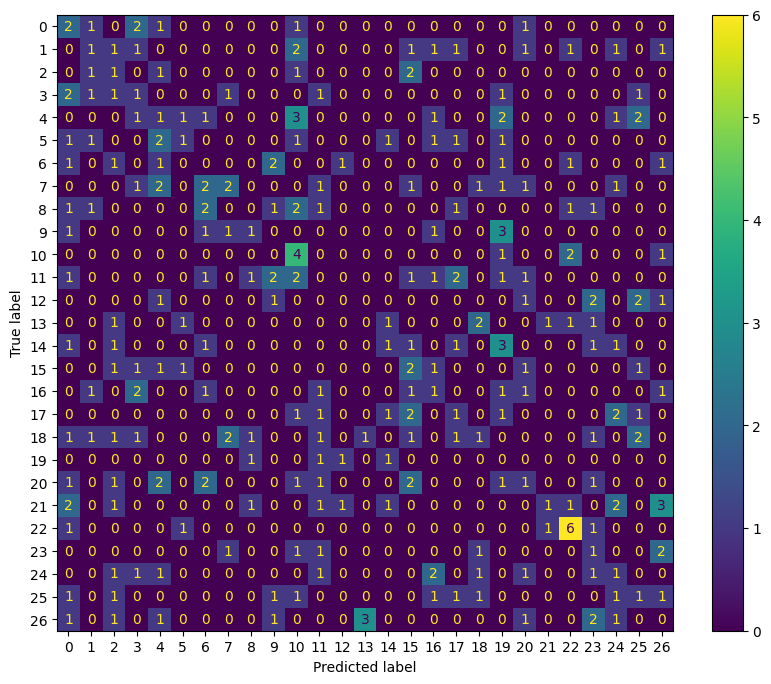

In [60]:
fig, axs = plt.subplots(figsize=(10, 8))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax = axs)

plt.show()

In [37]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='accuracy')  # You can change the metric if needed

# Print the cross-validation scores for each fold
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean and standard deviation of the scores
print(f"Mean accuracy: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.4f}")

Cross-validation scores: [0.13425926 0.18981481 0.14351852 0.14351852 0.08796296]
Mean accuracy: 0.1398
Standard deviation: 0.0324


In [21]:
random_choose = np.round(1 / len(np.unique(y_selected)), 4)
print(f'Probability of randomly choosing the correct class: {random_choose}')

Probability of randomly choosing the correct class: 0.037


We can see that the result, specially from the CV, is not much better than making a random guess, depending on the sub data set.

# Considering HOG

Now, we are going to consider the HOG features on the analysis.

In [61]:
y_model = df['label']  # Labels (target column)
X_model = df.drop('label', axis=1)  # Features (drop the 'label' column)

# Label encoding for the target labels
label_encoder = LabelEncoder()
y_model_encoded = label_encoder.fit_transform(y_model)

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model_encoded, test_size=0.2, random_state=42)

In [62]:
# Initialize the Random Forest Classifier
rf_classifier_HOG = RandomForestClassifier(n_estimators=400, max_depth=40, max_features='sqrt',random_state=42)

# Train the Random Forest Classifier on the training data
rf_classifier_HOG.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier_HOG.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report (precision, recall, f1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Optionally, decode the predictions back to original labels if needed
y_pred_labels = label_encoder.inverse_transform(y_pred)

Accuracy: 0.3741
Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.75      0.43         8
           1       1.00      0.17      0.29        12
           2       0.36      0.67      0.47         6
           3       0.27      0.44      0.33         9
           4       0.17      0.08      0.11        13
           5       0.20      0.20      0.20        10
           6       0.10      0.22      0.14         9
           7       0.40      0.15      0.22        13
           8       0.20      0.18      0.19        11
           9       0.33      0.38      0.35         8
          10       0.15      0.38      0.21         8
          11       0.20      0.08      0.11        13
          12       0.29      0.25      0.27         8
          13       0.55      0.75      0.63         8
          14       0.50      0.36      0.42        11
          15       0.50      0.33      0.40         9
          16       0.17      0.10      0.

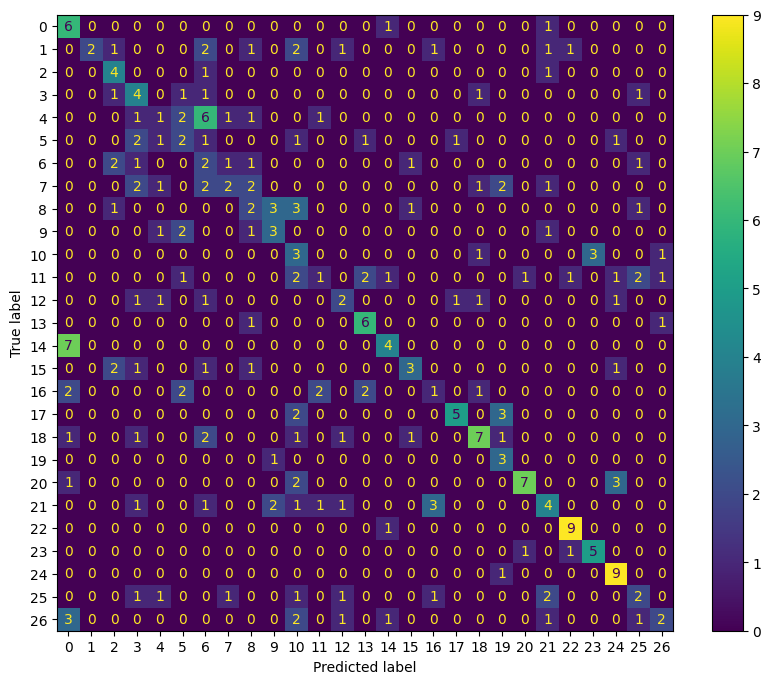

In [63]:
fig, axs = plt.subplots(figsize=(10, 8))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax = axs)

plt.show()

In [64]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_classifier_HOG, X_train, y_train, cv=5, scoring='accuracy')  # You can change the metric if needed

# Print the cross-validation scores for each fold
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean and standard deviation of the scores
print(f"Mean accuracy: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.4f}")

Cross-validation scores: [0.39814815 0.36574074 0.39814815 0.42592593 0.43055556]
Mean accuracy: 0.4037
Standard deviation: 0.0233


# Option 3: Amplifying the HOG features

We are going to define the extract_features function a little bit differently. 

In the previous version, the HOG features where calculated as:

hog_features = hog(image, pixels_per_cell=(16, 16), cells_per_block=(1, 1), channel_axis=None)

which outputed 576 hog features per image.

In an attempt to see if moreHOG features give higher accuracy (which risks higher chances of overfitting) we will define the following:

hog_features = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), channel_axis=None)

which should output 8100 hog features per image.

In [68]:
def extract_features(image):
    features = {}

    # Convert to grayscale if the image is in color
    if len(image.shape) == 3:
        image = rgb2gray(image)

    # 1. Hu Moments
    hu_moments = moments_hu(image)
    for i, moment in enumerate(hu_moments):
        features[f'hu_moment_{i}'] = moment

    # 2. HOG Features
    hog_features = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), channel_axis=None)
    hog_features = hog_features.flatten()
    for i, feature in enumerate(hog_features):
        features[f'hog_{i}'] = feature

    # 3. Local Binary Patterns (LBP)
    lbp = local_binary_pattern(image, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 60), density=True)  # 59 bins for uniform LBP
    for i, hist_value in enumerate(lbp_hist):
        features[f'lbp_hist_{i}'] = hist_value

    contours, _ = cv2.findContours(img_as_ubyte(image), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = max(contours, key=cv2.contourArea)

    # 4. Geometric Shape Features (Contour-based)
    if contours:
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = float(w) / h
        extent = area / (w * h)
        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        solidity = float(area) / hull_area
        features.update({
            'area': area,
            'perimeter': perimeter,
            'aspect_ratio': aspect_ratio,
            'extent': extent,
            'solidity': solidity
        })

    # 5. Haralick Texture Features (GLCM)
    glcm = graycomatrix(img_as_ubyte(image), distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
    features['contrast'] = graycoprops(glcm, 'contrast').mean()
    features['dissimilarity'] = graycoprops(glcm, 'dissimilarity').mean()
    features['homogeneity'] = graycoprops(glcm, 'homogeneity').mean()
    features['energy'] = graycoprops(glcm, 'energy').mean()
    features['correlation'] = graycoprops(glcm, 'correlation').mean()

    # 6. Skeletonization and Finger Count
    skeleton = skeletonize(image > 0.5)
    labeled_skeleton = skimage_label(skeleton)
    features['num_fingers'] = len(regionprops(labeled_skeleton))  # Rough count of fingers as separate regions

    # 7. Convex Hull Defects
    if contours:
        hull_points = cv2.convexHull(cnt, returnPoints=False)
        defects = cv2.convexityDefects(cnt, hull_points)
        features['num_defects'] = len(defects) if defects is not None else 0

    # 8. Statistical Pixel Intensity Features
    pixel_values = image.ravel()
    features['mean_intensity'] = np.mean(pixel_values)
    features['intensity_variance'] = np.var(pixel_values)
    features['intensity_skewness'] = skew(pixel_values)
    features['intensity_kurtosis'] = kurtosis(pixel_values)
    features['entropy'] = shannon_entropy(image)

    return features

ini_time = time.time()
# Initialize an empty list to hold all the feature vectors
all_features = []

# Iterate through each image in X and extract its features
print(len(X_selected))
for i, image in enumerate(X_selected):
    # Extract features for the current image
    features = extract_features(image)
    
    # Append the label to the features
    features['label'] = y_selected[i][0]
    
    # Append the feature dictionary to the list
    all_features.append(features)

    if i % 50 == 0:
        print(np.round(i / len(X_selected), 2))

end_time = time.time()

total_time = np.round((end_time - ini_time) / 60, 2)
print(f'It took a total of : {total_time} [min]')
# Convert the list of feature dictionaries into a DataFrame
df2 = pd.DataFrame(all_features)

1350
0.0


/home/coder/.local/lib/rolos-ml/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


0.04
0.07
0.11
0.15
0.19
0.22
0.26
0.3
0.33
0.37
0.41
0.44
0.48
0.52
0.56
0.59
0.63
0.67
0.7
0.74
0.78
0.81
0.85
0.89
0.93
0.96
It took a total of : 1.32 [min]


In [69]:
print(f'Amount of features: {df2.shape[1]}')
print(f'Amount of images: {df2.shape[0]}')

Amount of features: 8184
Amount of images: 1350


In [70]:
y_model = df2['label']  # Labels (target column)
X_model = df2.drop('label', axis=1)  # Features (drop the 'label' column)

# Label encoding for the target labels
label_encoder = LabelEncoder()
y_model_encoded = label_encoder.fit_transform(y_model)

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model_encoded, test_size=0.2, random_state=42)

In [71]:
# Initialize the Random Forest Classifier
rf_classifier_More_HOG = RandomForestClassifier(n_estimators=400, max_depth=40, max_features='sqrt',random_state=42)

# Train the Random Forest Classifier on the training data
rf_classifier_More_HOG.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier_More_HOG.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report (precision, recall, f1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Optionally, decode the predictions back to original labels if needed
y_pred_labels = label_encoder.inverse_transform(y_pred)

Accuracy: 0.3630
Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.88      0.50         8
           1       0.14      0.08      0.11        12
           2       0.16      0.67      0.26         6
           3       0.57      0.44      0.50         9
           4       0.33      0.23      0.27        13
           5       0.27      0.30      0.29        10
           6       0.11      0.11      0.11         9
           7       0.00      0.00      0.00        13
           8       0.50      0.36      0.42        11
           9       0.11      0.12      0.12         8
          10       0.27      0.38      0.32         8
          11       1.00      0.15      0.27        13
          12       0.45      0.62      0.53         8
          13       0.44      0.88      0.58         8
          14       0.44      0.36      0.40        11
          15       0.44      0.44      0.44         9
          16       0.10      0.10      0.

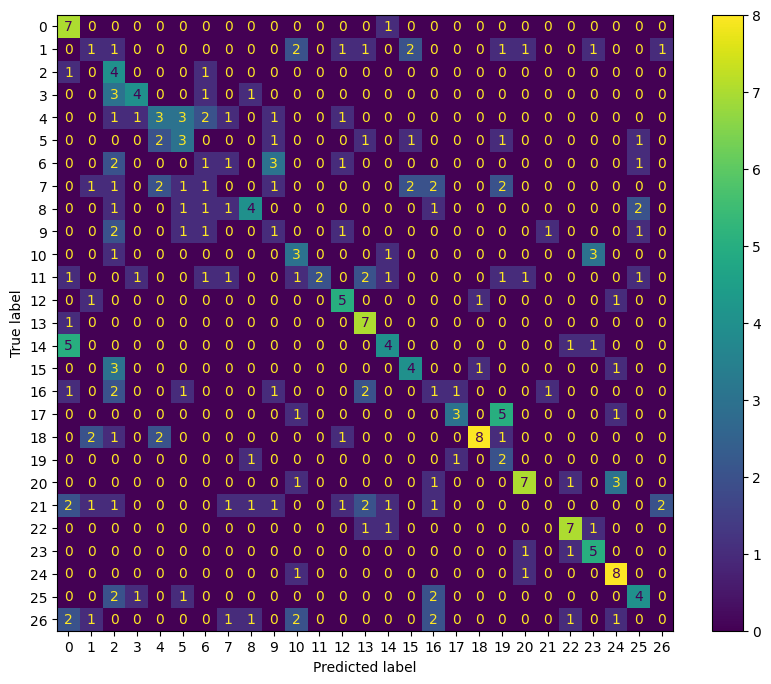

In [72]:
fig, axs = plt.subplots(figsize=(10, 8))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax = axs)

plt.show()

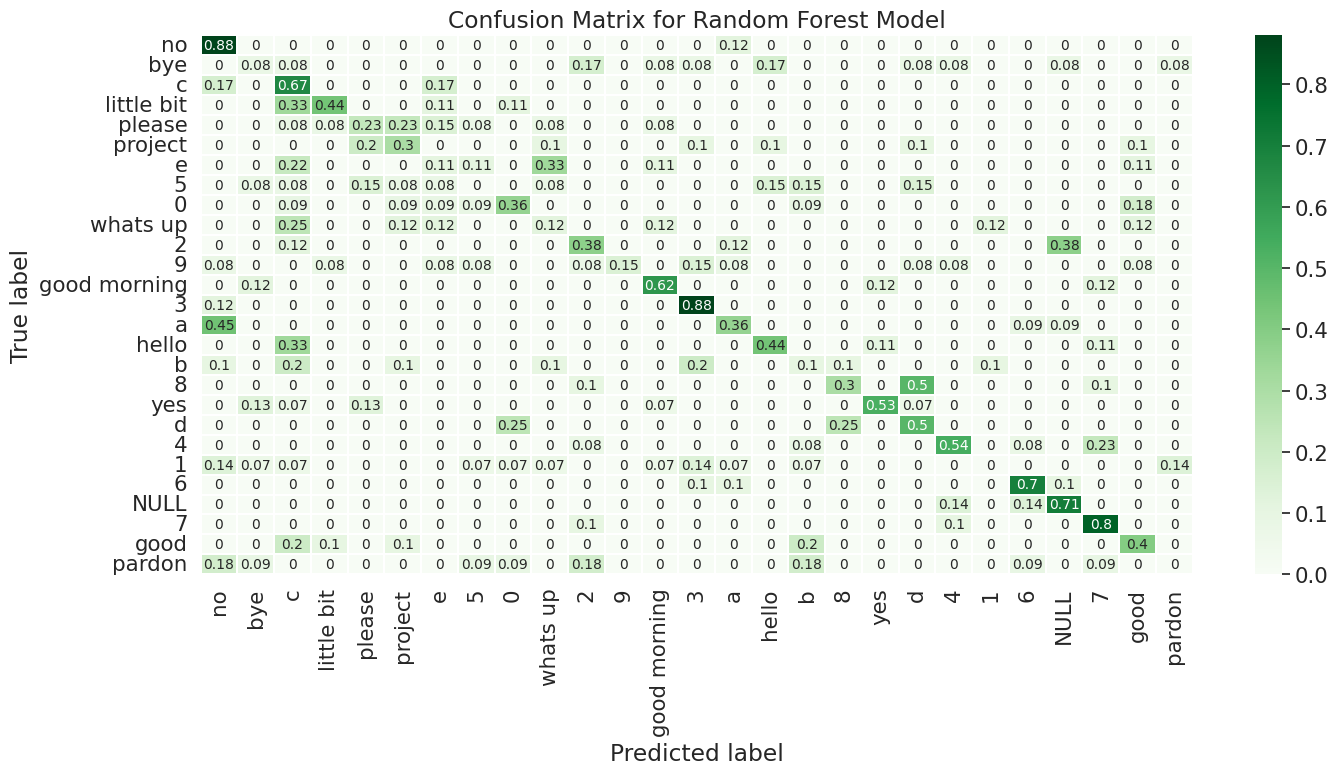

In [87]:
# A more meaningful version of the same matrix

# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
matrix = np.round(matrix, 2)

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = list(set(y_model))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks + 0.5, class_names, rotation=90)
plt.yticks(tick_marks + 0.5, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [73]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_classifier_More_HOG, X_train, y_train, cv=5, scoring='accuracy')  # You can change the metric if needed

# Print the cross-validation scores for each fold
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean and standard deviation of the scores
print(f"Mean accuracy: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.4f}")

Cross-validation scores: [0.39351852 0.375      0.39814815 0.37962963 0.41666667]
Mean accuracy: 0.3926
Standard deviation: 0.0148


As we see, the results even got a bit worse by adding more HOG values.

### It is still pending: 
1. Use other feature extractions, such as PCA instead of HOG
2. Use combined (if it makes sense), such as PCA along with HOG
3. Try other models, such as SVM, Naive Bayes, or KNN